## Heston Calibration with PyTorch Autograd\n

\n

This notebook loads call prices from `options_data.csv` and calibrates Heston parameters by\n

minimizing the mean squared error between market prices and Heston prices computed via the\n

Carr-Madan FFT implementation in `NN/heston_torch.py`. Calibration is done with PyTorch and\n

gradient-based optimization on an unconstrained parameter vector.

In [8]:
import math 

from pathlib import Path 

 

import numpy as np 

import pandas as pd 

import torch 

 

# Add Heston/NN module to path 

import sys 

root = Path.cwd()  # project root (IV_Euro)

sys.path.append(str(root / 'Heston' / 'NN')) 

 

from heston_torch import HestonParams, carr_madan_call_torch 

 

torch.set_default_dtype(torch.float64) 

device = torch.device('cpu') 

 

CSV_PATH = root / 'options_data.csv' 

df = pd.read_csv(CSV_PATH) 

required = {'S0', 'K', 'T', 'C_mkt'} 

missing = required - set(df.columns) 

if missing: 

    raise ValueError(f'Missing columns in options_data.csv: {missing}') 

df = df[list(required)].dropna().copy() 

n_total = len(df) 

max_points = 300 

if n_total > max_points: 

    # Stratified subsample over maturities to keep diversity 

    df = df.sort_values('T') 

    idx = np.linspace(0, n_total - 1, max_points, dtype=int) 

    df = df.iloc[idx] 

df = df.reset_index(drop=True) 

print(f'Calibration on {len(df)} quotes (out of {n_total}).') 

df.head() 

Calibration on 300 quotes (out of 895).


,C_mkt,S0,K,T
0,93.78,671.929993,570.0,0.004065
1,85.62,671.929993,580.0,0.004065
2,58.22,671.929993,615.0,0.004065
3,37.00,671.929993,635.0,0.004065
4,29.92,671.929993,640.0,0.004065


In [9]:
# Prepare tensors 

S0_t = torch.tensor(df['S0'].to_numpy(), dtype=torch.float64, device=device) 

K_t = torch.tensor(df['K'].to_numpy(), dtype=torch.float64, device=device) 

T_t = torch.tensor(df['T'].to_numpy(), dtype=torch.float64, device=device) 

C_mkt_t = torch.tensor(df['C_mkt'].to_numpy(), dtype=torch.float64, device=device) 

 

r = 0.02  # assume constant risk-free rate 

q = 0.0   # assume zero dividend yield 

print('T range: ', float(T_t.min()), '→', float(T_t.max())) 

T range:  0.0040652934562721 → 0.8396817318124365


In [10]:
def prices_from_unconstrained(u: torch.Tensor) -> torch.Tensor: 

    """Map unconstrained 5D vector u to valid HestonParams, then price all calls.""" 

    params = HestonParams.from_unconstrained(u[0], u[1], u[2], u[3], u[4]) 

    prices = [] 

    for S0_i, K_i, T_i in zip(S0_t, K_t, T_t): 

        price_i = carr_madan_call_torch(S0_i, r, q, T_i, params, K_i) 

        prices.append(price_i) 

    return torch.stack(prices) 

 

def loss(u: torch.Tensor) -> torch.Tensor: 

    model_prices = prices_from_unconstrained(u) 

    diff = model_prices - C_mkt_t 

    return 0.5 * (diff ** 2).mean() 

In [11]:
# Optimization: Adam on unconstrained parameters u 

u = torch.tensor([1.0, -3.0, -0.5, -0.5, -3.0], dtype=torch.float64, device=device, requires_grad=True) 

optimizer = torch.optim.Adam([u], lr=5e-3) 

max_iters = 60 

history = [] 

for it in range(max_iters): 

    optimizer.zero_grad() 

    L = loss(u) 

    L.backward() 

    optimizer.step() 

    history.append(float(L.detach().cpu())) 

    if it % 5 == 0: 

        print(f'Iter {it:03d} | loss = {history[-1]:.6e}') 

history[-5:] 

Iter 000 | loss = 1.617958e+02
Iter 005 | loss = 1.612805e+02
Iter 010 | loss = 1.608774e+02
Iter 015 | loss = 1.605763e+02
Iter 020 | loss = 1.603515e+02
Iter 025 | loss = 1.601674e+02
Iter 030 | loss = 1.599926e+02
Iter 035 | loss = 1.598110e+02
Iter 040 | loss = 1.596212e+02
Iter 045 | loss = 1.594285e+02
Iter 050 | loss = 1.592376e+02
Iter 055 | loss = 1.590505e+02


[159.05048157956446,
 159.01351121995214,
 158.97667831622314,
 158.93997662786234,
 158.90340053867354]

In [12]:
# Inspect calibrated parameters (mapped to constrained space) 

with torch.no_grad(): 

    params_fin = HestonParams.from_unconstrained(u[0], u[1], u[2], u[3], u[4]) 

calib_dict = { 

    'kappa': float(params_fin.kappa.cpu()), 

    'theta': float(params_fin.theta.cpu()), 

    'sigma': float(params_fin.sigma.cpu()), 

    'rho': float(params_fin.rho.cpu()), 

    'v0'  : float(params_fin.v0.cpu()), 

} 

pd.Series(calib_dict, name='Calibrated Heston parameters') 

kappa    1.132673
theta    0.047996
sigma    0.582199
rho     -0.374231
v0       0.046052
Name: Calibrated Heston parameters, dtype: float64

,iteration,loss
55,55,159.050482
56,56,159.013511
57,57,158.976678
58,58,158.939977
59,59,158.903401


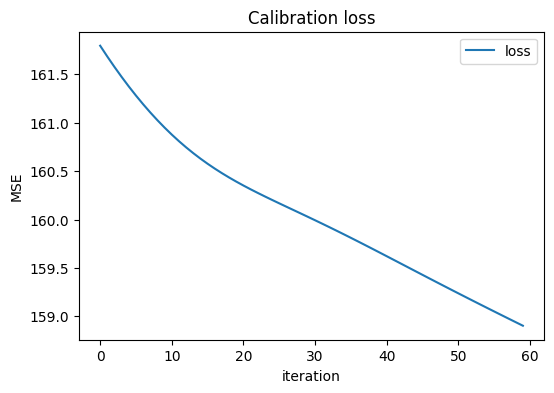

In [13]:
# Loss history
loss_df = pd.DataFrame({'iteration': range(len(history)), 'loss': history})
display(loss_df.tail())
ax = loss_df.plot(x='iteration', y='loss', kind='line', figsize=(6,4), title='Calibration loss');
ax.set_ylabel('MSE');


,S0,K,T,C_mkt,C_heston
0,671.929993,570.0,0.004065,93.78,101.976334
1,671.929993,580.0,0.004065,85.62,91.977147
2,671.929993,615.0,0.004065,58.22,56.979992
3,671.929993,635.0,0.004065,37.00,36.981774
4,671.929993,640.0,0.004065,29.92,31.983112
5,671.929993,645.0,0.004065,28.15,26.989997
6,671.929993,654.0,0.004065,19.65,18.094153
7,671.929993,657.0,0.004065,15.83,15.220460
8,671.929993,660.0,0.004065,12.23,12.429902
9,671.929993,663.0,0.004065,9.91,9.833981


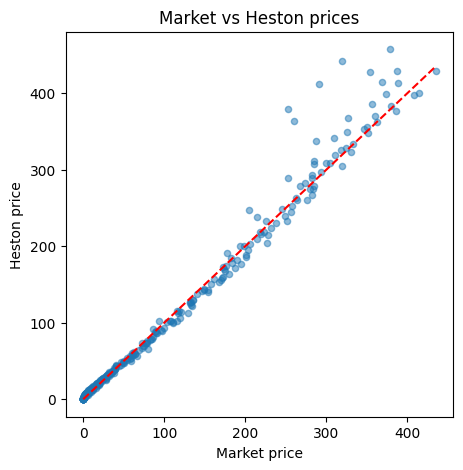

In [14]:
# Market vs Heston model prices (sample)
with torch.no_grad():
    model_prices = prices_from_unconstrained(u).cpu().numpy()
cmp_df = df.copy()
cmp_df['C_heston'] = model_prices
display(cmp_df[['S0','K','T','C_mkt','C_heston']].head(10))
ax2 = cmp_df.plot(x='C_mkt', y='C_heston', kind='scatter', alpha=0.5, figsize=(5,5), title='Market vs Heston prices');
ax2.set_xlabel('Market price');
ax2.set_ylabel('Heston price');
ax2.plot([cmp_df['C_mkt'].min(), cmp_df['C_mkt'].max()], [cmp_df['C_mkt'].min(), cmp_df['C_mkt'].max()], 'r--');
